*Notebook adapted from https://camtsmith.com/articles/2021-03/language-similarity*

Main change is that I'm using ISO393 instead of Langiage Name to request distances

# Sound Similarity

In this notebook I create an algorithm to determine which languages sound most like one another. The results are interesting. If you'd like to read a condensed version, there's [a blog post](https://camtsmith.com/articles/2021-03/language-similarity).


## Preliminaries

Phonemes are the sounds that occur in a language. For instance, /kʰ/ is the first sound in the English word _king_, and /ŋ/ is the sound of _ng_. [The International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet) is the system that linguists use to transcribe the sounds of words - it lets us escape all the messiness of a particular language's spelling rules. In IPA, we'd transcribe the word "king" as /kʰɪŋ/. As you may have already noticed, linguists put IPA transcriptions inside of forward /slæʃɪz/.

You can compare the sounds in different languages by simply counting which phonemes overlap. This is one of the methods that I employ below. However, when you look at the consonant chart in the IPA, you'll realize that just like words can be broken down into individual speech sounds, speech sounds themselves can be defined as combinations of a _place of articulation_ and a _manner of articulation_. For instance, the sound /kʰ/ is a _velar plosive_ - your tongue makes contact with the __velum__ in your mouth, and the sound __explodes__ outwards -- place of articulation: velar; manner of articulation: plosive. Speech sounds also have other features, like voicing (whether your vocal cords vibrate) - /kʰ/ is voiceless, but /g/ is its voiced counterpart. In fact, there are 38 phoneme features tracked by phoible, and I make use of them all.

What this means is that in addition to treating phonemes discretely, we can also break them down into their constituent attributes to get a more fine-grained measure of similarity. For instance /kʰ/ is more similar to /k/ than to /m/ (a bilabial nasal sound). I use both strategies when developing metrics.  I'll be experimenting with a _vector space model_ where I use all of these features.

Most of the data I'm using is from [Phoible](https://phoible.org/), so you can head over there and thank them. I've also made use of [WALS](https://wals.info/) for some rough exploratory research and [Glottolog](https://glottolog.org/) for information about language families 😃

In this notebook, I'll first acquire some data and explore it. Then I'll experiment with some similarity metrics. I'll choose a metric and perform some evaluations on it. Finally, I'll wrap everything up and talk about what sound similarity tells us about the English language.

## Data Acquisition

In this section, I download the Phoible dataset and get it into a format that's easy to work with. I then load it into a dataframe to show you what the data looks like.

In [3]:
! curl https://raw.githubusercontent.com/phoible/dev/master/data/phoible.csv > phoible.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C


In [6]:
! mkdir -p data

In [7]:
! mv phoible.csv data/

In [20]:
import pandas as pd

In [21]:
df = pd.read_csv("data/phoible.csv")

/home/maureen/anaconda3/envs/lfe/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
df.head()

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,0,0,+,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,0,0,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,0,0,-,-,-,+,-,-,-,-


In [23]:
df[df["LanguageName"] == "Farsi"]

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click


## Data Exploration

In this section I'm going to look at the overall distribution of language features and answer some basic questions: which languages have the largest phoneme inventories? Which languages are the most consonant-heavy? etc.

In [24]:
# All the features from SegmentClass onwards (except Source) are phoneme- (segment) specific features.
df.columns

Index(['InventoryID', 'Glottocode', 'ISO6393', 'LanguageName',
       'SpecificDialect', 'GlyphID', 'Phoneme', 'Allophones', 'Marginal',
       'SegmentClass', 'Source', 'tone', 'stress', 'syllabic', 'short', 'long',
       'consonantal', 'sonorant', 'continuant', 'delayedRelease',
       'approximant', 'tap', 'trill', 'nasal', 'lateral', 'labial', 'round',
       'labiodental', 'coronal', 'anterior', 'distributed', 'strident',
       'dorsal', 'high', 'low', 'front', 'back', 'tense',
       'retractedTongueRoot', 'advancedTongueRoot', 'periodicGlottalSource',
       'epilaryngealSource', 'spreadGlottis', 'constrictedGlottis', 'fortis',
       'raisedLarynxEjective', 'loweredLarynxImplosive', 'click'],
      dtype='object')

In [25]:
# Get the data into SQL format so it's easier to run queries against.
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)
df.to_sql('phoible', con=engine)

In [26]:
# Group by `InventoryID, LanguageName` because `LanguageName` is not unique:
# some languages have dialects: `SpecificDialect` column.
res = engine.execute("""
               SELECT AVG(cnt) FROM (SELECT ISO6393, COUNT(DISTINCT Phoneme) AS cnt
               FROM phoible
               GROUP BY InventoryID, ISO6393)
               """
              ).fetchall()

print(f"The average language has {res[0][0]:.1f} phonemes")

The average language has 36.1 phonemes


In [27]:
res = engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               """
              ).fetchall()

print(f"The languages with the greatest number of phonemes are:")
res[:10]

The languages with the greatest number of phonemes are:


[('!Xóõ', 161),
 ('!XU', 141),
 ('!Xun', 120),
 ('Hindi-Urdu', 94),
 ('Dan', 92),
 ('ARCHI', 91),
 ('Yeyi', 90),
 ('Nizaa', 90),
 ('Xhosa', 84),
 ('Siraiki', 83)]

In [28]:
print(f"The languages with the smallest number of phonemes are:")
list(reversed(res[-10:]))

The languages with the smallest number of phonemes are:


[('Bijogo', 10),
 ('ROTOKAS', 11),
 ('PIRAHA', 11),
 ('NASIOI', 13),
 ('HAWAIIAN', 13),
 ('Abau', 14),
 ('TAORIPI', 14),
 ('RORO', 14),
 ('Namia', 15),
 ('Jarawara', 15)]

Most languages have around 20-50 phonemes, though there are a few with a lot more


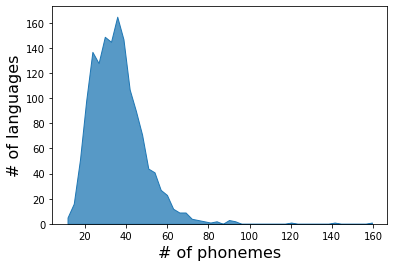

In [29]:
# Let's graph the distribution of phoneme inventory sizes
import seaborn as sns
import matplotlib.pyplot as plt

plt.xlabel('# of phonemes', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")
print("Most languages have around 20-50 phonemes, though there are a few with a lot more")

In [30]:
res = engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               """
              ).fetchall()

print(f"The languages with the greatest number of vowels are:")
res[:10]

The languages with the greatest number of vowels are:


[('So', 50),
 ('!XU', 46),
 ('PARAUK', 43),
 ('Dan', 40),
 ('Karimojong', 39),
 ('Dinka, South Central', 37),
 ('Apinaye', 35),
 ('Siraiki', 35),
 ('Acehnese', 34),
 ('Lama', 33)]

In [31]:
print(f"The languages with the fewest number of vowels are:")
list(reversed(res[-10:]))

The languages with the fewest number of vowels are:


[('Buwal', 2),
 ('Cuvok', 2),
 ('Zulgo', 2),
 ('Dghwede', 3),
 ('bana', 3),
 ('Arrarnte', 3),
 ('Aklan', 3),
 ('Iñupiaq; Iñupiat; Inupiat; Inupiaq', 3),
 ('Kabyle', 3),
 ('Garadjari', 3)]

In [32]:
res = engine.execute("""
               SELECT x.LanguageName, y.cons_cnt / CAST(x.vowel_cnt AS float) AS ratio FROM
               (SELECT InventoryID, LanguageName, COUNT(*) AS vowel_cnt
               FROM phoible x
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName) AS x
               JOIN
               (SELECT InventoryID, LanguageName, COUNT(*) AS cons_cnt
               FROM phoible x
               WHERE SegmentClass = 'consonant'
               GROUP BY InventoryID, LanguageName) AS y
               ON x.InventoryID = y.InventoryID
               ORDER BY ratio DESC
               """
              ).fetchall()

print(f"The languages with the highest ratio of consonants to vowels are:")
res[:10]

The languages with the highest ratio of consonants to vowels are:


[('Buwal', 19.0),
 ('Moroccan Arabic', 18.5),
 ('Haida', 15.666666666666666),
 ('HAIDA', 15.333333333333334),
 ('Zulgo', 14.5),
 ('Cuvok', 13.5),
 ('TSIMSHIAN', 12.666666666666666),
 ('Ikalanga', 12.4),
 ('bana', 12.333333333333334),
 ('Copi', 12.2)]

In [33]:
print(f"The languages with the lowest ratio of consonants to vowels are:")
list(reversed(res[-10:]))

The languages with the lowest ratio of consonants to vowels are:


[('Apinaye', 0.4),
 ('So', 0.44),
 ('Binandere', 0.4583333333333333),
 ('Lama', 0.5151515151515151),
 ('Waama', 0.52),
 ('Karimojong', 0.5384615384615384),
 ('Apurinã', 0.5384615384615384),
 ('Dinka, South Central', 0.5405405405405406),
 ('Nateni', 0.5416666666666666),
 ('Wobé', 0.5555555555555556)]

Most languages have 1 to 5 consonants per vowel


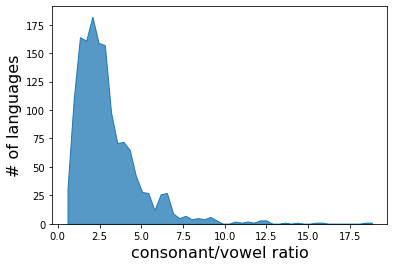

In [34]:
plt.xlabel('consonant/vowel ratio', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")
print("Most languages have 1 to 5 consonants per vowel")

In [35]:
res = engine.execute(f"""
               SELECT DISTINCT(LanguageName), SegmentClass
               FROM phoible
               WHERE SegmentClass = 'tone'
               """
              ).fetchall()

print("These are some languages that have tones:")
res[:10]

These are some languages that have tones:


[('Burushaski', 'tone'),
 ('Vietnamese', 'tone'),
 ('Mandarin Chinese', 'tone'),
 ('Wu', 'tone'),
 ('Hakka', 'tone'),
 ('Cantonese', 'tone'),
 ('Yao', 'tone'),
 ('Dafla', 'tone'),
 ('Burmese', 'tone'),
 ('Lahu', 'tone')]

In [36]:
# Which languages lack nasal sounds i.e. /n/, /m/?
res = engine.execute("""
               SELECT x.LanguageName, SUM(x.nasal) AS num_nasals
               FROM (SELECT InventoryID, LanguageName,
               CASE WHEN nasal = '-' THEN 0 ELSE 1 END AS nasal
               FROM phoible) AS x
               GROUP BY InventoryID, x.LanguageName
               ORDER BY num_nasals ASC
               """
              ).fetchall()

print("These are some unusual languages that lack nasal sounds")
res[:16]

# The final language, Najdi Arabic, definitely contains nasal sounds - so this might be an error!
# Error reported: https://github.com/phoible/dev/issues/332

These are some unusual languages that lack nasal sounds


[('LUSHOOTSEED', 0),
 ('PIRAHA', 0),
 ('QUILEUTE', 0),
 ('ROTOKAS', 0),
 ('Hup', 0),
 ('Tatuyo', 0),
 ('Xamtanga', 0),
 ('TLINGIT', 1),
 ('TAORIPI', 1),
 ('Samo', 1),
 ('Secoya', 1),
 ('Baule', 1),
 ('Welamo', 1),
 ('Lak', 2),
 ('Kabardian', 2),
 ('Georgian', 2)]

## Language Comparison

In this section, I'm going to get the data into a format that's useful for doing comparisons. There are several ways to do this:

- Map each language to a list of all its phonemes, i.e. `"English": ["a", "e", "i", "b", ...]`
- Map each language to a vector representing the presence of absence of a given phoneme, i.e. `"English": [0, 0, 1, 0, ...]`. This binary vector is equal to the length of all the phonemes in the database.
- Map each language to a vector of vectors, where each sub-vector are the features of each phoneme, i.e `English: [[0, 1, 1, ...], [1, 1, 0, ...], ...]`

Each of these representations allow for different types of distance metrics, so I'll be trying out lots of measurement types. I took inspiration from [this paper](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Gardner_Measuring_Distance_Between_2014_CVPR_paper.pdf) about measuring the distances between sets.

Also, it's important to keep in mind the complexity of these different distance metrics. In order to determine the closest pair of languages, it's necessary to compute the distance between every pair of languages, which is $n^2$ computations. Furthermore, the distance metric itself has its own complexity, which I'll call $d$. That means the complexity of generating all the paired distances between all the languages is actually $dn^2$, which might be large. Luckily, we can ask specific questions instead, like _what is the distance between English and Arabic?_ which has a complexity of just $d$. I'll be using American English for all of my comparisons.

### Overlap Coefficient

The [overlap coefficient](https://en.wikipedia.org/wiki/Overlap_coefficient) is a useful measure of similarity, but is limited when sets are different in size. For instance, a language like _Pirahã_ will be ranked as closer to English than it should be, simply because Pirahã has very few phonemes (and those phonemes happen to be a subset of English's phonemes). In other words, languages with small phoneme inventories like Pirahã will be closer to _every_ other language, so this metric is also measuring "smallness" of a language's phoneme inventory, which we might not care about.

On the other hand, the overlap coefficient might be useful if you consider it _asymmetrically_ - an English speaker who wants to learn Pirahã should have an easier time learning the phonemes than an English speaker learning Thai. However, distance metrics are always symmetrical, so the distance between English and Pirahã is the same as the distance from Pirahã to English - so this metric is only useful when you consider going from a large-inventory language to a small-inventory language, which requires additional logic outside the metric itself.

__Note__: I subtracted the overlap coefficient from `1` in order to convert this to distance: larger values equal greater distance.

In [37]:
# Create mappings like "English": ["a", "e", "i", "b", ...]
res = engine.execute("""
               SELECT ISO6393, group_concat(DISTINCT Phoneme)
               FROM phoible
               GROUP BY InventoryID, ISO6393
               """
              ).fetchall()

# Turn this into a dict.
# Warning: this uses LanguageName as the key, which is not unique
# so if there two languages called Chinese, only one will make it into this dict
simple_mapping = {k: v.split(",") for k, v in res}

# # Show an example.
print("These are all the phonemes that occur in English:")
print(simple_mapping["eng"])

These are all the phonemes that occur in English:
['b', 'd', 'd̠ʒ', 'f', 'h', 'j', 'kʰ', 'l', 'm', 'n', 'pʰ', 's', 'tʰ', 't̠ʃ', 'v', 'w', 'x', 'z', 'ð', 'ŋ', 'ɡ', 'ɻ', 'ʃ', 'ʍ', 'ʒ', 'ʔ', 'θ', 'aː', 'e̞', 'iː', 'o̞ː', 'uː', 'æ', 'ɐ', 'ɒ', 'ɔ', 'ə', 'əː', 'ɪ', 'ʊ']


Note : We are losing some information when using ISO69393 (eg English Dialects), but better for our use.

In [38]:
print(f"There are {len(simple_mapping['eng'])} phonemes in  English")

There are 40 phonemes in  English


In [39]:
# Define the overlap distance between two sets.
def overlap_distance(a, b):
    a, b = set(a), set(b)
    
    return 1 - len(a.intersection(b)) / min([len(a), len(b)])


# Calculate distances between some languages
overlap_d_eng_fr = overlap_distance(simple_mapping["eng"], simple_mapping["fra"])
overlap_d_eng_germ = overlap_distance(simple_mapping["eng"], simple_mapping["deu"])
overlap_d_fr_germ = overlap_distance(simple_mapping["fra"], simple_mapping["deu"])

print(f"The overlap distance between English and French is {overlap_d_eng_fr:.3f}")
print(f"The overlap distance between English and German is {overlap_d_eng_germ:.3f}")
print(f"The overlap distance between French and German is {overlap_d_fr_germ:.3f}")

The overlap distance between English and French is 0.676
The overlap distance between English and German is 0.400
The overlap distance between French and German is 0.541


In [40]:
# Now let's find the overlap distance between English and every other language.
overlap_distance_to_eng = [(overlap_distance(simple_mapping["eng"], simple_mapping[lang]), lang) for lang in simple_mapping]

In [41]:
print("The 50 languages with the closest overlap distance to American English:")
# Note: I am indexing from the third item in the list
# because the first two will always be "American English" and "English (American)"
sorted(overlap_distance_to_eng, key=lambda x: x[0])[2:52]

The 50 languages with the closest overlap distance to American English:


[(0.3125, 'xjb'),
 (0.31999999999999995, 'amp'),
 (0.33333333333333337, 'tun'),
 (0.33333333333333337, 'kmn'),
 (0.34375, 'lun'),
 (0.3448275862068966, 'hag'),
 (0.34615384615384615, 'kun'),
 (0.34782608695652173, 'tgl'),
 (0.34782608695652173, 'ivv'),
 (0.35, 'aey'),
 (0.35, 'nla'),
 (0.35, 'mua'),
 (0.35, 'bbj'),
 (0.3513513513513513, 'nds'),
 (0.3529411764705882, 'chr'),
 (0.3548387096774194, 'bun'),
 (0.3571428571428571, 'diu'),
 (0.36, 'iba'),
 (0.36, 'kws'),
 (0.36363636363636365, 'top'),
 (0.36363636363636365, 'yaq'),
 (0.36363636363636365, 'lmp'),
 (0.36363636363636365, 'hum'),
 (0.3666666666666667, 'fvr'),
 (0.3666666666666667, 'ker'),
 (0.3666666666666667, 'ndo'),
 (0.368421052631579, 'bak'),
 (0.37037037037037035, 'bbc'),
 (0.375, 'som'),
 (0.375, 'dbl'),
 (0.375, 'yii'),
 (0.375, 'dzg'),
 (0.3793103448275862, 'hay'),
 (0.38095238095238093, 'tlo'),
 (0.38095238095238093, 'cho'),
 (0.38095238095238093, 'sgz'),
 (0.3846153846153846, 'snv'),
 (0.3846153846153846, 'ctd'),
 (0.38

The results returned by this algorithm aren't unreasonable: many of the top languages are other English dialects, as well as closely related languages like Scots and German. This is much better than random, but there are some unexpected languages like Burmese. I think we can use an even better distance metric, Jaccard distance, which I introduce in the next section. Before that though, let's check out some of the least similar languages:

In [42]:
print("The 25 languages with the furthest overlap distance from English:")
sorted(overlap_distance_to_eng, key=lambda x: x[0])[-25:]

The 25 languages with the furthest overlap distance from English:


[(0.7714285714285715, 'yrk'),
 (0.7714285714285715, 'kmw'),
 (0.7727272727272727, 'usa'),
 (0.775, 'nab'),
 (0.775, 'tli'),
 (0.775, 'apu'),
 (0.775, 'wal'),
 (0.7777777777777778, 'ess'),
 (0.7777777777777778, 'kgp'),
 (0.78125, 'itl'),
 (0.7857142857142857, 'srq'),
 (0.8, 'mbl'),
 (0.8076923076923077, 'kpz'),
 (0.8095238095238095, 'guq'),
 (0.8148148148148149, 'klu'),
 (0.8181818181818181, 'roo'),
 (0.8285714285714285, 'bhg'),
 (0.8333333333333334, 'apn'),
 (0.8333333333333334, 'fun'),
 (0.8421052631578947, 'irh'),
 (0.84375, 'new'),
 (0.85, 'naq'),
 (0.8620689655172413, 'wic'),
 (0.8636363636363636, 'kal'),
 (0.875, 'chq')]

### Jaccard Distance

A more generally applicable metric, which accounts for differing set sizes, is the [Jaccard Distance](https://en.wikipedia.org/wiki/Jaccard_index), aka intersection over union. I repeated the same examples below, except I changed the distance metric. Notice that _German_ is ranked as closest to English, which matches our intuition about closeness (Thai and Pirahã are not in the same [language family](https://en.wikipedia.org/wiki/Germanic_languages) that English and German belong to).

In [43]:
# Define the Jaccard distance between two sets.
def jaccard_distance(a, b):
    a, b = set(a), set(b)
    
    return 1 - len(a.intersection(b)) / len(a.union(b))


# Calculate distances between some languages
jaccard_d_eng_fr = jaccard_distance(simple_mapping["eng"], simple_mapping["fra"])
jaccard_d_eng_germ = jaccard_distance(simple_mapping["eng"], simple_mapping["deu"])
jaccard_d_fr_germ = jaccard_distance(simple_mapping["fra"], simple_mapping["deu"])

print(f"The Jaccard distance between English and French is {jaccard_d_eng_fr:.3f}")
print(f"The Jaccard distance between English and German is {jaccard_d_eng_germ:.3f}")
print(f"The Jaccard distance between French and German is {jaccard_d_fr_germ:.3f}")

The Jaccard distance between English and French is 0.815
The Jaccard distance between English and German is 0.579
The Jaccard distance between French and German is 0.721


In [44]:
# Now let's find the jaccard distance between English and every other language.
jaccard_distance_to_eng = [(jaccard_distance(simple_mapping["eng"], simple_mapping[lang]), lang) for lang in simple_mapping]

In [45]:
print("The 50 languages with the closest Jaccard distance to  English:")
sorted(jaccard_distance_to_eng, key=lambda x: x[0])[2:52]

The 50 languages with the closest Jaccard distance to  English:


[(0.5555555555555556, 'bak'),
 (0.5789473684210527, 'deu'),
 (0.5882352941176471, 'lun'),
 (0.5961538461538461, 'lmp'),
 (0.5961538461538461, 'hum'),
 (0.6, 'fmp'),
 (0.6, 'aig'),
 (0.6041666666666667, 'kwn'),
 (0.6065573770491803, 'xsm'),
 (0.607843137254902, 'bun'),
 (0.6111111111111112, 'amo'),
 (0.6111111111111112, 'tuq'),
 (0.6111111111111112, 'kcn'),
 (0.6140350877192983, 'lis'),
 (0.6153846153846154, 'som'),
 (0.6153846153846154, 'dzg'),
 (0.6181818181818182, 'kwl'),
 (0.62, 'hag'),
 (0.6206896551724138, 'bgj'),
 (0.6226415094339622, 'jam'),
 (0.625, 'ses'),
 (0.6274509803921569, 'fvr'),
 (0.6274509803921569, 'ker'),
 (0.6274509803921569, 'ndo'),
 (0.6290322580645161, 'lns'),
 (0.631578947368421, 'bcs'),
 (0.631578947368421, 'bax'),
 (0.631578947368421, 'agj'),
 (0.6333333333333333, 'sld'),
 (0.6363636363636364, 'bzj'),
 (0.6379310344827587, 'izr'),
 (0.639344262295082, 'taq'),
 (0.64, 'diu'),
 (0.640625, 'djm'),
 (0.6415094339622642, 'mwt'),
 (0.6415094339622642, 'bvm'),
 (0.64

In [46]:
import itertools

#missing "fas" farsi. Instead use pes
#can't use esperanto, doesn't exist.

lang_list=["arb", "cat", "ces", "cym","deu","eng","pes","spa", "eus", "fra","fry", "ita","kab","nld", "pol", "por", "rus","kin","swe","tam","tur","tat","ukr","cmn"]

all_combinations = list(itertools.combinations(lang_list, 2))
all_combinations = list(itertools.combinations_with_replacement(lang_list, 2))
jaccard_distances = [((a,b),jaccard_distance(simple_mapping[a], simple_mapping[b])) for a,b in all_combinations]

KeyError: 'arb'

In [49]:

with open('tmp.csv', 'w') as outfile:
    for x in jaccard_distances:
        outfile.write("{}-{},{}\n".format(x[0][0], x[0][1], x[1]))

NameError: name 'jaccard_distances' is not defined

In [48]:
all_combinations

[('arb', 'arb'),
 ('arb', 'cat'),
 ('arb', 'ces'),
 ('arb', 'cym'),
 ('arb', 'deu'),
 ('arb', 'eng'),
 ('arb', 'pes'),
 ('arb', 'spa'),
 ('arb', 'eus'),
 ('arb', 'fra'),
 ('arb', 'fry'),
 ('arb', 'ita'),
 ('arb', 'kab'),
 ('arb', 'nld'),
 ('arb', 'pol'),
 ('arb', 'por'),
 ('arb', 'rus'),
 ('arb', 'kin'),
 ('arb', 'swe'),
 ('arb', 'tam'),
 ('arb', 'tur'),
 ('arb', 'tat'),
 ('arb', 'ukr'),
 ('arb', 'cmn'),
 ('cat', 'cat'),
 ('cat', 'ces'),
 ('cat', 'cym'),
 ('cat', 'deu'),
 ('cat', 'eng'),
 ('cat', 'pes'),
 ('cat', 'spa'),
 ('cat', 'eus'),
 ('cat', 'fra'),
 ('cat', 'fry'),
 ('cat', 'ita'),
 ('cat', 'kab'),
 ('cat', 'nld'),
 ('cat', 'pol'),
 ('cat', 'por'),
 ('cat', 'rus'),
 ('cat', 'kin'),
 ('cat', 'swe'),
 ('cat', 'tam'),
 ('cat', 'tur'),
 ('cat', 'tat'),
 ('cat', 'ukr'),
 ('cat', 'cmn'),
 ('ces', 'ces'),
 ('ces', 'cym'),
 ('ces', 'deu'),
 ('ces', 'eng'),
 ('ces', 'pes'),
 ('ces', 'spa'),
 ('ces', 'eus'),
 ('ces', 'fra'),
 ('ces', 'fry'),
 ('ces', 'ita'),
 ('ces', 'kab'),
 ('ces', 'nld'

The results returned by this algorithm seem reasonable. The closest languages to American English are other English dialects and German, a closely related language. Most of the other languages on the list make sense: they're English-based creoles, Western European languages, languages influenced by British colonization (Maltest), or other Indo-European languages. Some languages, however, seem out of place: there are many languages from the Niger-Congo family and some Austronesian languages. We'll see if the same kind of languages are returned by the other metrics.

Also, let's peek at which languages the algorithm says are furthest from English.

In [28]:
print("The 25 languages with the furthest Jaccard distance from American English:")
sorted(jaccard_distance_to_eng, key=lambda x: x[0])[-25:]

The 25 languages with the furthest Jaccard distance from American English:


[(0.9310344827586207, "Ngan'gityemerri"),
 (0.9322033898305084, 'Kala Kawaw Ya'),
 (0.9322033898305084, 'Kala Lagaw Ya'),
 (0.9333333333333333, 'HIGHLAND CHINANTEC'),
 (0.9333333333333333, 'PANARE'),
 (0.9344262295081968, 'SEBEI'),
 (0.935483870967742, 'KLAO'),
 (0.9361702127659575, 'PIRAHA'),
 (0.9384615384615385, 'IATE'),
 (0.9384615384615385, 'Paraguayan Guaraní'),
 (0.9387755102040817, 'NASIOI'),
 (0.94, 'RORO'),
 (0.94, 'TAORIPI'),
 (0.9402985074626866, 'ITELMEN'),
 (0.9411764705882353, 'GADSUP'),
 (0.9417989417989419, '!Xóõ'),
 (0.9454545454545454, 'IRARUTU'),
 (0.9473684210526316, 'ACHE'),
 (0.9473684210526316, 'KALIAI'),
 (0.9473684210526316, 'NAMA'),
 (0.9482758620689655, 'INUIT'),
 (0.9538461538461538, 'WICHITA'),
 (0.9649122807017544, 'MAXAKALI'),
 (0.9795918367346939, 'ROTOKAS'),
 (0.9838709677419355, 'Chiriguano')]

I'm happy that _!Xóõ_ made it onto this list: !Xóõ is a language with a __monstrous__ number of consonants, including [click sounds](https://en.wikipedia.org/wiki/Click_consonant) and tones!

In [29]:
print("These are all the phonemes that occur in !Xóõ:")
print(simple_mapping["!Xóõ"])

These are all the phonemes that occur in !Xóõ:
['b', 'd', 'dx', 'dʱ', 'dʼkxʼ', 'd̪', 'd̪x', 'd̪ʱ', 'd̪ʼkxʼ', 'f', 'h', 'k', 'kxʼ', 'kǀ', 'kǀh', 'kǀkxʼ', 'kǀx', 'kǀʔ', 'kǀʰ', 'kǁ', 'kǁh', 'kǁkxʼ', 'kǁx', 'kǁʔ', 'kǁʰ', 'kǂ', 'kǂh', 'kǂkxʼ', 'kǂx', 'kǂʔ', 'kǂʰ', 'kǃ', 'kǃh', 'kǃkxʼ', 'kǃx', 'kǃʔ', 'kǃʰ', 'kʘ', 'kʘh', 'kʘkxʼ', 'kʘx', 'kʘʔ', 'kʘʰ', 'kʰ', 'kʼ', 'l', 'm', 'n̪', 'p', 'pʰ', 'pʼkxʼ', 'q', 'qǀ', 'qǀʼ', 'qǁ', 'qǁʼ', 'qǂ', 'qǂʼ', 'qǃ', 'qǃʼ', 'qʘ', 'qʘʼ', 'qʰ', 'qʼ', 's', 't', 'tx', 'tʰ', 'tʼ', 'tʼkxʼ', 't̪', 't̪x', 't̪ʰ', 't̪ʼ', 't̪ʼkxʼ', 'x', 'ŋǀ', 'ŋǁ', 'ŋǂ', 'ŋǃ', 'ŋʘ', 'ŋ̊ǀ', 'ŋ̊ǁ', 'ŋ̊ǂ', 'ŋ̊ǃ', 'ŋ̊ʘ', 'ɟ', 'ɡ', 'ɡǀ', 'ɡǀkxʼ', 'ɡǀkʰ', 'ɡǀx', 'ɡǁ', 'ɡǁkxʼ', 'ɡǁkʰ', 'ɡǁx', 'ɡǂ', 'ɡǂkxʼ', 'ɡǂkʰ', 'ɡǂx', 'ɡǃ', 'ɡǃkxʼ', 'ɡǃkʰ', 'ɡǃx', 'ɡʘ', 'ɡʘkxʼ', 'ɡʘkʰ', 'ɡʘx', 'ɡʱ', 'ɡʼkxʼ', 'ɢ', 'ɢǀ', 'ɢǀqʰ', 'ɢǁ', 'ɢǁqʰ', 'ɢǂ', 'ɢǃ', 'ɢǃqʰ', 'ɢʘ', 'ɢʱ', 'ɲ', 'ɸ', 'ʔ', 'ʔŋǀ', 'ʔŋǁ', 'ʔŋǂ', 'ʔŋǃ', 'ʔŋʘ', 'ˀm', 'ˀn', '˦', '˧', '˨', 'a', 'aˤ', 'ã', 'a̤', 'a̰', 'aᴱ', 'e', 'eˤ', 'ẽ', 'e̤', 'ḛ

### Simple Matching Coefficient

[The Simple Matching Coefficient](https://en.wikipedia.org/wiki/Simple_matching_coefficient) for two equal-length arrays is the number of matching elements divided by the length of the array. This only works for vectors that are equal length, so below I map each language to a binary vector that represents the presence or absence of a given phoneme.

Because the average inventory size is 34.9 (see above) and the total number of phonemes is 3164 (see below), each binary vector will be sparse (mostly zeros), meaning that distance measures will all be _close_ to each other. However, even though the numbers themselves are close, distance can still be ranked, and the total differences can always be scaled.

I subtracted this coefficient from `1` to turn it into a distance metric.

Note: [Hamming Distance](https://en.wikipedia.org/wiki/Hamming_distance) is the same as the simple matching coefficient except is defined between equal-length strings instead of equal-length arrays.

In [95]:
phoneme_list = engine.execute("""
                SELECT GROUP_CONCAT(DISTINCT(Phoneme)) FROM phoible
               """
              ).fetchall()

# List of distinct phonemes
total_phoneme_inventory = list(phoneme_list[0])[0].split(",")
print(f"Here is what some of the phoneme data looks like: {total_phoneme_inventory[:10]}")
print(f"There are {len(total_phoneme_inventory)} phonemes total")

Here is what some of the phoneme data looks like: ['h', 'j', 'k', 'kʰ', 'kˀ', 'l', 'm', 'n', 'p', 'pʰ']
There are 3164 phonemes total


In [96]:
# Create mapping like "English": [1, 1, 0, 1, ...]
def create_binary_encoding(language_phoneme_inventory, total_phoneme_inventory=total_phoneme_inventory):
    return [1 if phone in language_phoneme_inventory else 0 for phone in total_phoneme_inventory]


binary_encoding = {k: create_binary_encoding(v) for k, v in simple_mapping.items()}

In [98]:
# Show what part of the binary encoding for English looks like
binary_encoding["eng"][:10]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 0]

In [99]:
# Confirm the number of phonemes in American English
sum(binary_encoding["eng"])

40

In [100]:
# Define the simple matching coefficient between two equal-length vectors
def simple_matching_coef(a, b):
    len_overlap = len([1 for i, j in zip(a, b) if i == j])
    
    return 1 - len_overlap / len(a)



In [101]:
# Now let's find the matching distance between English and every other language.
simple_distance_to_eng = [(simple_matching_coef(binary_encoding["eng"], binary_encoding[lang]), lang) for lang in simple_mapping]

In [36]:
print("The 50 languages with the smallest simple matching distance from English:")
sorted(simple_distance_to_eng, key=lambda x: x[0])[2:52]

The 50 languages with the smallest simple matching distance from English:


[(0.006953223767383054, 'English (British)'),
 (0.007901390644753481, 'English'),
 (0.008849557522123908, 'Persian'),
 (0.008849557522123908, 'kwangari'),
 (0.009165613147914087, 'English (Australian)'),
 (0.009481668773704155, 'Hanga'),
 (0.009481668773704155, 'Low German'),
 (0.009481668773704155, 'Scots'),
 (0.009481668773704155, 'Farsi'),
 (0.009797724399494334, 'BASHKIR'),
 (0.009797724399494334, 'Daza'),
 (0.009797724399494334, 'diriku'),
 (0.009797724399494334, 'Northern Kurdish'),
 (0.010113780025284402, 'IVATAN'),
 (0.010113780025284402, 'Teda'),
 (0.010113780025284402, 'Belizean Creole'),
 (0.010113780025284402, 'kwezo'),
 (0.010113780025284402, 'Sherbro'),
 (0.010113780025284402, 'Cebuano'),
 (0.010113780025284402, 'Juhuri'),
 (0.010429835651074582, 'German'),
 (0.010429835651074582, 'Azerbaijani'),
 (0.010429835651074582, 'KERA'),
 (0.010429835651074582, 'KUNAMA'),
 (0.010429835651074582, 'FARSI'),
 (0.010429835651074582, 'TUNICA'),
 (0.010429835651074582, 'Lunda'),
 (0.010

The results returned by this algorithm also seem reasonable. Again, many of the closest languages are other English dialects, other Indo-European langauges, and some creole languages. But I think we can do better...

In [37]:
print("The 25 languages with the furthest simple matching distance from English:")
sorted(simple_distance_to_eng, key=lambda x: x[0])[-25:]

The 25 languages with the furthest simple matching distance from English:


[(0.02718078381795197, 'LAK'),
 (0.02749683944374215, 'Yeyi'),
 (0.027812895069532217, 'Tofa'),
 (0.028128950695322397, 'Lak'),
 (0.028445006321112465, 'PARAUK'),
 (0.028445006321112465, 'Mfumte'),
 (0.028761061946902644, 'Nizaa'),
 (0.02939317319848289, 'Moroccan Arabic'),
 (0.02939317319848289, 'Scottish Gaelic'),
 (0.03002528445006325, 'Xhosa'),
 (0.03002528445006325, 'Tashlhiyt Berber'),
 (0.03002528445006325, 'Nangchenpa Tibetan'),
 (0.030341340075853318, 'Rigwe'),
 (0.030341340075853318, 'Elfdalian'),
 (0.030657395701643497, 'Dan'),
 (0.031289506953223745, 'Hindi-Urdu'),
 (0.0331858407079646, 'Lezgian'),
 (0.0331858407079646, 'Shixing'),
 (0.03476611883691527, 'ARCHI'),
 (0.0357142857142857, 'Mbembe'),
 (0.04140328697850826, '!Xun'),
 (0.042351453855878685, 'Soghpo Tibetan'),
 (0.04582806573957021, 'Kildin Saami'),
 (0.04614412136536028, '!XU'),
 (0.05625790139064479, '!Xóõ')]

The distributions of distances from English seems to be normally distributed


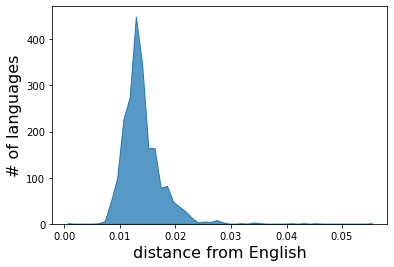

In [102]:
# Let's also explore the distribution of distances

plt.xlabel('distance from English', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for i, _ in simple_distance_to_eng], bins=50, element="poly")
print("The distributions of distances from English seems to be normally distributed")

### Vector Space Similarity

In this algorithm, I first map each phoneme to a set of binary features. There are 37 of these features. When comparing two languages, I calculate the distance between each phoneme in each language and take the average of the closest features. The sub-distance metric I use is jaccard distance. 


In [103]:
# Columns 11 and onward are phoneme feature columns
# I decided not to use the column `SegmentClass` because it can be inferred from the other features
cols = list(df.columns[11:])
print(f"There are {len(cols)} segment features total:")
print(cols)

There are 37 segment features total:
['tone', 'stress', 'syllabic', 'short', 'long', 'consonantal', 'sonorant', 'continuant', 'delayedRelease', 'approximant', 'tap', 'trill', 'nasal', 'lateral', 'labial', 'round', 'labiodental', 'coronal', 'anterior', 'distributed', 'strident', 'dorsal', 'high', 'low', 'front', 'back', 'tense', 'retractedTongueRoot', 'advancedTongueRoot', 'periodicGlottalSource', 'epilaryngealSource', 'spreadGlottis', 'constrictedGlottis', 'fortis', 'raisedLarynxEjective', 'loweredLarynxImplosive', 'click']


In [106]:
# Make language mapping like English: [[0, 1, 1, ...], [1, 1, 0, ...], ...]
res = engine.execute(f"""
               SELECT ISO6393, {", ".join(cols)}
               FROM phoible
               """
              ).fetchall()

# res = [[i[0].split(",")[0], list(i[0].split(",")[1])]for i in list(res)]

vector_mapping = {}
for i in res:
    lang = i[0]
    features = i[1:]
    if lang not in vector_mapping:
        vector_mapping[lang] = [features]
    else:
        vector_mapping[lang].append(features)

In [108]:
for i in range(3):
    print(vector_mapping["eng"][i])

('0', '-', '-', '-', '-', '+', '-', '-', '-', '-', '-', '-', '-', '-', '+', '-', '-', '-', '0', '0', '0', '-', '0', '0', '0', '0', '0', '0', '0', '+', '-', '-', '-', '-', '-', '-', '-')
('0', '-', '-', '-', '-', '+', '-', '-', '-', '-', '-', '-', '-', '-', '-', '0', '0', '+', '+', '-', '-', '-', '0', '0', '0', '0', '0', '0', '0', '+', '-', '-', '-', '-', '-', '-', '-')
('0', '-', '-', '-', '-', '+', '-', '-', '+', '-', '-', '-', '-', '-', '-', '0', '0', '+', '-', '+', '+', '-', '0', '0', '0', '0', '0', '0', '0', '+', '-', '-', '-', '-', '-', '-', '-')


In [110]:
# Define the vector space similarity between two languages
def vector_similarity(a, b):
    """
    Calculate the jaccard distance between all of a's vectors and all of b's vectors
    The overall vector space similarity is simply the average distance.
    This works fine where the phoneme inventories are different sizes
    """
    simple_distances = []
    
    # For each vector in a, find the closest vector in b and append it to simple_distances
    for vec_a in a:
        closest = 1
        for vec_b in b:
            distance = simple_matching_coef(vec_a, vec_b)
            if distance < closest:
                closest = distance
        simple_distances.append(closest)
    
    # For each vector in b, find the closest vector in a and append it to simple_distances
    for vec_b in b:
        closest = 1
        for vec_a in a:
            distance = simple_matching_coef(vec_a, vec_b)
            if distance < closest:
                closest = distance
        simple_distances.append(closest)
    
    # Return the average distance
    return sum(simple_distances) / len(simple_distances)


# Calculate distances between some languages
vec_similarity_d_eng_germ = vector_similarity(vector_mapping["eng"], vector_mapping["deu"])

print(f"The vector distance for English and German is {vec_similarity_d_eng_germ:.3f}")


The vector distance for English and German is 0.015


In [111]:
# Now let's find the matching distance between English and every other language.
# Be patient, this might take a minute!
# vec_distance_to_eng = [(vector_similarity(vector_mapping["eng"], vector_mapping[lang]), lang) for lang in vector_mapping]

In [44]:
print("The 50 languages with the smallest vector distance from English:")
sorted(vec_distance_to_eng, key=lambda x: x[0])[2:52]

The 50 languages with the smallest vector distance from English:


[(0.011452130096197886, 'English (British)'),
 (0.013098988559111253, 'English'),
 (0.017258222077499174, 'English (Australian)'),
 (0.020813917365641484, 'Welsh'),
 (0.02154857560262964, 'Belizean Creole'),
 (0.021692745376955886, 'Scots'),
 (0.02207841644461361, 'Daza'),
 (0.02214714714714713, 'Jamaican Creole'),
 (0.02275059869996578, 'German'),
 (0.023112767940354138, 'Assamese'),
 (0.023341523341523326, 'kwangari'),
 (0.023717595146166563, 'Persian'),
 (0.023739956172388586, 'Teda'),
 (0.023868023868023853, 'BASHKIR'),
 (0.023938223938223924, 'Rumanian'),
 (0.0239817282070803, 'Karipuna Creole'),
 (0.023986486486486467, 'Michif'),
 (0.02408348943002407, 'Indonesian'),
 (0.024255024255024238, 'Tagalog'),
 (0.024285154719937307, 'KERA'),
 (0.024324324324324312, 'Berom'),
 (0.024601524601524576, 'Ishkashimi'),
 (0.02483564645726806, 'Wymysorys'),
 (0.024974341430037614, 'Cebuano'),
 (0.025068546807677217, 'FUR'),
 (0.025294525294525284, 'Hill Jarawa'),
 (0.025437201907790127, 'Hanga'

In [115]:
import itertools

#missing "fas" farsi. Instead use pes
lang_list=["cat","cym","deu","eng","pes","fra","ita","kab","kin"]

all_combinations = list(itertools.combinations(lang_list, 2))
vec_distances = [((a,b),vector_similarity(vector_mapping[a], vector_mapping[b])) for a,b in all_combinations]

In [116]:
vec_distances

[(('cat', 'cym'), 0.02999858497240698),
 (('cat', 'deu'), 0.030416555169030385),
 (('cat', 'eng'), 0.02697434276381642),
 (('cat', 'pes'), 0.026095060577819223),
 (('cat', 'fra'), 0.019478098788443636),
 (('cat', 'ita'), 0.012969012969012962),
 (('cat', 'kab'), 0.04483674425870962),
 (('cat', 'kin'), 0.022240990990990996),
 (('cym', 'deu'), 0.018581081081081075),
 (('cym', 'eng'), 0.016099831889305596),
 (('cym', 'pes'), 0.022142624552263106),
 (('cym', 'fra'), 0.02910602910602912),
 (('cym', 'ita'), 0.03036744609778319),
 (('cym', 'kab'), 0.046084546084546076),
 (('cym', 'kin'), 0.029256060183895233),
 (('deu', 'eng'), 0.014584395716471205),
 (('deu', 'pes'), 0.020999416682869934),
 (('deu', 'fra'), 0.01857557883616517),
 (('deu', 'ita'), 0.030848089468779136),
 (('deu', 'kab'), 0.04338549075391183),
 (('deu', 'kin'), 0.024570024570024558),
 (('eng', 'pes'), 0.021821001329198026),
 (('eng', 'fra'), 0.022426682001150052),
 (('eng', 'ita'), 0.025351351351351317),
 (('eng', 'kab'), 0.047

The results here look even better than simple Jaccard distance: the top languages are all English dialects or related languages, languages spoken in the British Isles (Wales), other Indo-European languages, or languages that have been strongly influenced by English (Maltese, Jamaican Creole, Belizean Creole), or the usual Niger-Congo and Austronesian languages. There are some outliers though, like _Tamasheq_, a Berber language spoken in Mali, but [its phonology](https://en.wikipedia.org/wiki/Tamasheq_language#Phonology) does look similar to English.

In the next section, I'm going to be a little more specific in how I measure the success of this distance metric.

In [45]:
print("The 25 languages with the largest vector distance from English:")
sorted(vec_distance_to_eng, key=lambda x: x[0])[-25:]

The 25 languages with the largest vector distance from English:


[(0.0918918918918919, 'cilungu'),
 (0.09195228748301366, 'Dan'),
 (0.09206081081081079, 'Mbembe'),
 (0.09222380275011849, 'Kom'),
 (0.09260423213911578, 'Nizaa'),
 (0.092726873214678, 'Xhosa'),
 (0.09334544628662274, 'Konkomba'),
 (0.09413908290312784, 'soninke (kaedi (MRT))'),
 (0.09420099711361841, 'Sandawe'),
 (0.0948544698544698, 'Gwandara (Nimbia)'),
 (0.09508599508599501, 'Ticuna'),
 (0.095223130106851, 'Attie'),
 (0.09672830725462297, 'Ngiti'),
 (0.09702009702009701, 'Sochiapan Chinantec'),
 (0.09856915739268676, 'Gwandara (Karshi)'),
 (0.09878844361602983, 'Gadsup'),
 (0.09962028143846319, 'Babungo'),
 (0.10135135135135136, 'NAMA'),
 (0.10196560196560189, 'Bafut'),
 (0.10435435435435429, '!XU'),
 (0.10937996820349756, 'Buli'),
 (0.11036036036036034, 'Nama'),
 (0.1112146629388008, 'Itunyoso Trique'),
 (0.12748597654258026, '!Xun'),
 (0.14270270270270255, '!Xóõ')]

We already know that !Xóõ is very different from English, but let's explore a couple of others:

In [46]:
print("These are all the phonemes that occur in Xhosa:")
print(simple_mapping["Xhosa"])

These are all the phonemes that occur in Xhosa:
['b̤', 'cʰ', 'cʼ', 'd̠̤ʒ̤', 'd̤', 'f', 'h', 'j', 'kxʰ', 'kxʼ', 'kǀ', 'kǀʰ', 'kǀʼ', 'kǁ', 'kǁʰ', 'kǃ', 'kǃʰ', 'kʰ', 'kʼ', 'l', 'm', 'mpfʼ', 'mpʼ', 'm̤', 'm̤b̤', 'm̤b̤v̤', 'n', 'ntlʼ', 'ntsʼ', 'ntʼ', 'n̠t̠ʃʼ', 'n̠̤d̠̤ʒ', 'n̤', 'n̤d̤', 'n̤d̤z̤', 'n̤d̤ɮ̤', 'pʰ', 'pʼ', 's', 'tsʰ', 'tsʼ', 'tʰ', 'tʼ', 't̠ʃʰ', 't̠ʃʼ', 'v̤', 'w', 'x', 'z̤', 'ŋ', 'ŋkʼ', 'ŋǀ', 'ŋǁ', 'ŋǁʼ', 'ŋǃ', 'ŋǃʼ', 'ŋ̤ǀ', 'ŋ̤ǁ', 'ŋ̤ǃ', 'ŋ̤ɡ̤', 'ɓ', 'ɟ̤', 'ɡ̤', 'ɡ̤ǀ', 'ɡ̤ǁ', 'ɡ̤ǃ', 'ɣ̤', 'ɦ̤', 'ɬ', 'ɮ̤', 'ɲ', 'ɲcʼ', 'ɲ̤', 'ɲ̤ɟ̤', 'ʃ', '˦', '˨', 'a', 'e', 'i', 'o', 'u', 'ɔ', 'ɛ']


In [47]:
print("These are all the phonemes that occur in Nizaa:")
print(simple_mapping["Nizaa"])

These are all the phonemes that occur in Nizaa:
['b', 'd', 'dʷ', 'd̠ʒ', 'd̠ʒʷ', 'f', 'h', 'j', 'k', 'kp', 'kʷ', 'l', 'lʷ', 'm', 'mb', 'mʷ', 'n', 'nd', 'ndʷ', 'nz', 'nzʷ', 'nʷ', 'n̠d̠ʒ', 'n̠d̠ʒʷ', 'p', 's', 'sʷ', 't', 'tʷ', 't̠ʃ', 't̠ʃʷ', 'v', 'w', 'w̃', 'x', 'z', 'zʷ', 'ŋmɡb', 'ŋɡ', 'ŋɡʷ', 'ɓ', 'ɓʷ', 'ɗ', 'ɗʷ', 'ɡ', 'ɡb', 'ɡʷ', 'ɥ', 'ɰ̃', 'ɱv', 'ɲ', 'ɲʷ', 'ɾ', 'ɾʷ', 'ʃ', 'ʃʷ', 'ʔ', 'ʔʷ', '˦', '˦˧', '˦˨', '˧', '˧˨', '˨', '˨˦', '˨˦˧', '˨˧', 'a', 'aː', 'ãː', 'e', 'eː', 'iː', 'ĩː', 'o', 'oː', 'uː', 'ũː', 'ɔː', 'ɔ̃ː', 'ɛː', 'ɛ̃ː', 'ɤː', 'ɤ̃ː', 'ɪ', 'ɯː', 'ɯ̃ː', 'ʊ', 'ʌː', 'ʌ̃ː']


## Evaluation

One way to evaluate this custom distance metric is to simply look at the results: do they look sensible? A "sensible" result should have lots of languages in the same family as English: Indo-European. If a lot of the results are Indo-European, then the results are probably good. This seems to be the case. Rather than just counting things manually, let's quantify it.

In this section I first join the phoible dataset with [glottolog](https://glottolog.org/). Glottolog contains meta-data about languages: where it's spoken, the countries it's spoken in, etc.

If my algorithm's top-50 items contain 25 Indo-European languages, and 50% of the world's languages are members of this family, then the algorithm's results are probably random. If, however, the distribution of language families that are selected by my algorithm are significantly different from the distribution in WALS, that means that my algorithm is doing _something_.

Here's how I evaluate the results:
- If there are significantly __more__ Indo-European languages chosen than random, then my algorithm is _valid_ - it's returning sensible results.
- If my algorithm returns _some other language family_ significantly more than chance, then this family _probably_ resembles English in its phonology.

First I'll just show you the raw probabilities, then I'll use statistics to quantify things.

__Note__: the choice of the top 50 languages is arbitrary. I could choose another number. Additionally, I could weight each item by distance, but this complicates some of the downstream calculations.

In [48]:
! curl https://raw.githubusercontent.com/glottolog/glottolog-cldf/master/cldf/languages.csv > languages.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1547k  100 1547k    0     0  3765k      0 --:--:-- --:--:-- --:--:-- 3756k


In [49]:
! mv languages.csv ../data

In [50]:
lang_df = pd.read_csv("../data/languages.csv")

In [51]:
lang_df.head()

,ID,Name,Macroarea,Latitude,Longitude,Glottocode,ISO639P3code,Countries,Family_ID,Language_ID
0,kond1302,Konda-Yahadian,NaN,NaN,NaN,kond1302,NaN,NaN,NaN,NaN
1,cani1243,Canichana,South America,-14.3058,-64.944455,cani1243,caz,BO,NaN,NaN
2,mong1349,Mongolic-Khitan,NaN,NaN,NaN,mong1349,NaN,NaN,NaN,NaN
3,cadd1255,Caddoan,NaN,NaN,NaN,cadd1255,NaN,NaN,NaN,NaN
4,yuki1242,Yuki-Wappo,NaN,NaN,NaN,yuki1242,NaN,NaN,NaN,NaN


In [52]:
# Join phoible to glottolog to see which languages are part of the Indo-European family
engine = create_engine('sqlite://', echo=False)
lang_df.to_sql('glottolog', con=engine)
df.to_sql('phoible', con=engine)

res = engine.execute("""
               SELECT DISTINCT(phoible.LanguageName), glottolog.Family_ID FROM glottolog
               JOIN phoible
               ON phoible.Glottocode = glottolog.Glottocode
               WHERE Family_ID LIKE '%indo%'
               """
              ).fetchall()

print("Here are some examples of Indo-European languages:")
res[:10]

Here are some examples of Indo-European languages:


[('GREEK', 'indo1319'),
 ('Greek', 'indo1319'),
 ('Modern Greek', 'indo1319'),
 ('Italian', 'indo1319'),
 ('Aragonese', 'indo1319'),
 ('Ligurian', 'indo1319'),
 ('Friulian', 'indo1319'),
 ('Vallader Romansh', 'indo1319'),
 ('Reunionnais', 'indo1319'),
 ('Mauritian Creole', 'indo1319')]

In [53]:
# Get the names of the languages
top_50_lang_names = [name for _, name in sorted(vec_distance_to_eng, key=lambda x: x[0])[2:52]]

In [54]:
# Add `phoible` and `glottolog` tables so that they can be joined.
engine = create_engine('sqlite://', echo=False)
lang_df.to_sql('glottolog', con=engine)
df.to_sql('phoible', con=engine)

# Add a new column `family` to analyze family distributions.
res = engine.execute(f"""
               SELECT DISTINCT(phoible.LanguageName), glottolog.Family_ID
               FROM glottolog
               JOIN phoible
               ON phoible.Glottocode = glottolog.Glottocode
               """
              ).fetchall()

# Get all the languages in the database along with their language family.
total_langs_in_database = res


res = engine.execute(f"""
               SELECT DISTINCT(phoible.LanguageName), glottolog.Family_ID FROM glottolog
               JOIN phoible
               ON phoible.Glottocode = glottolog.Glottocode
               AND phoible.LanguageName IN ('{"','".join(top_50_lang_names)}')
               """
              ).fetchall()

# Get the top-50 languages along with their language family
top_50_langs = res

Let's look at the families of the top-50 languages and see if anything pops out. At first glance, it seems like there are more Austronesian languages (`aust1307`) than might occur by chance, so we'll investigate that! Niger-Congo (`atla1278`) looks promising too:

In [55]:
top_50_non_indo = sorted([i for i in top_50_langs if i[1] != 'indo1319'], key=lambda x: x[1])
top_50_non_indo

[('KERA', 'afro1255'),
 ('Michif', 'algi1248'),
 ('Swahili', 'atla1278'),
 ('AMO', 'atla1278'),
 ('KOHUMONO', 'atla1278'),
 ('TEKE', 'atla1278'),
 ('Berom', 'atla1278'),
 ('Chumburung', 'atla1278'),
 ('Hanga', 'atla1278'),
 ('Kabiyɛ', 'atla1278'),
 ('Hill Jarawa', 'atla1278'),
 ('Lunda', 'atla1278'),
 ('mbukushu', 'atla1278'),
 ('diriku', 'atla1278'),
 ('kwangari', 'atla1278'),
 ('Javanese', 'aust1307'),
 ('Tagalog', 'aust1307'),
 ('IVATAN', 'aust1307'),
 ('Toba-Batak', 'aust1307'),
 ('Indonesian', 'aust1307'),
 ('Taba', 'aust1307'),
 ('Cebuano', 'aust1307'),
 ('Standard Malay', 'aust1307'),
 ('CAYAPA', 'barb1265'),
 ('FUR', 'fura1235'),
 ('San Miguel Chimalapa Zoque', 'mixe1284'),
 ('LUO', 'nilo1247'),
 ('Daza', 'saha1256'),
 ('Teda', 'saha1256'),
 ('BASHKIR', 'turk1311')]

In [56]:
# Calculate the fractions of Indo-European, Austronesian, and Niger-Congo languages in the entire database
cnt_langs_in_database = len(total_langs_in_database)
indo_langs_in_database = [1 if i[1]  == 'indo1319' else 0 for i in total_langs_in_database]
austro_langs_in_database = [1 if i[1]  == 'aust1307' else 0 for i in total_langs_in_database]
niger_langs_in_database = [1 if i[1]  == 'atla1278' else 0 for i in total_langs_in_database]

In [57]:
# Calculate the fractions of Indo-European, Austronesian, and Niger-Congo languages in the top-50
cnt_langs_in_sample = len(top_50_langs)
indo_langs_in_sample = [1 if i[1]  == 'indo1319' else 0 for i in top_50_langs]
niger_langs_in_sample = [1 if i[1]  == 'atla1278' else 0 for i in top_50_langs]
austro_langs_in_sample = [1 if i[1]  == 'aust1307' else 0 for i in top_50_langs]

In [58]:
print(f"The fraction of Indo-European languages in the database is {sum(indo_langs_in_database)/cnt_langs_in_database*100:.0f}%")
print(f"The fraction of Austronesian languages in the database is {sum(austro_langs_in_database)/cnt_langs_in_database*100:.0f}%")
print(f"The fraction of Niger-Congo languages in the database is {sum(niger_langs_in_database)/cnt_langs_in_database*100:.0f}%")

The fraction of Indo-European languages in the database is 7%
The fraction of Austronesian languages in the database is 5%
The fraction of Niger-Congo languages in the database is 18%


In [59]:
print(f"The fraction of Indo-European languages in the top-50 is: {sum(indo_langs_in_sample)/cnt_langs_in_sample*100:.0f}%")
print(f"The fraction of Austronesian languages in the top-50 is: {sum(austro_langs_in_sample)/cnt_langs_in_sample*100:.0f}%")
print(f"The fraction of Niger-Congo languages in the top-50 is: {sum(niger_langs_in_sample)/cnt_langs_in_sample*100:.0f}%")

The fraction of Indo-European languages in the top-50 is: 40%
The fraction of Austronesian languages in the top-50 is: 16%
The fraction of Niger-Congo languages in the top-50 is: 26%


If we just eyeball the numbers, we can tell that the algorithm is valid: only __7%__ of the world's languages are Indo-European, but __40%__ of the languages in the top 50 were Indo-European.

Additionally, __5%__ of the world's languages are Austronesian, but __16%__ of the languages in the sample are.

It also looks like Niger-Congo languages might be more similar: only __18%__ of the world's languages are Niger-Congo, but __26%__ of the top-50 are from this family. However, these numbers are pretty close - let's do some math to explicitly determine how likely these results would have occured by chance. If these results are unlikely to have occured by chance, then they're valid!

In [60]:
# Independent-samples t-test for Indo-European languages
from scipy import stats

t_test_indo = stats.ttest_ind(indo_langs_in_database, indo_langs_in_sample)

print(f"The probability that the difference between the two means would have occured by chance is {t_test_indo.pvalue}")

The probability that the difference between the two means would have occured by chance is 1.4647640644606805e-18


This means that it's _very very_ unlikely we would have gotten these results by chance. The algorithm is having _an effect_ - Indo-European langugages are being selected at a much higher rate than chance.

In [61]:
# Independent-samples t-test for Austronesian languages
from scipy import stats

t_test_austro = stats.ttest_ind(austro_langs_in_database, austro_langs_in_sample)

print(f"The probability that the difference between the two means would have occured by chance is {t_test_austro.pvalue}")

The probability that the difference between the two means would have occured by chance is 0.00033112080890767404


It's also very unlikely that so many Austronesian languages would have been selected by chance. This suggests that this family _actually does_ sound more like English than languages from other families. This result is interesting, because Austronesian languages originated on the opposite side of the world from the British Isles and have no genetic relationship to English.

Let's see what happens when we look at the Niger-Congo languages:

In [62]:
# Independent-samples t-test for Niger-Congo languages
from scipy import stats

t_test_niger = stats.ttest_ind(niger_langs_in_database, niger_langs_in_sample)

print(f"The probability that the difference between the two means would have occured by chance is {t_test_niger.pvalue}")

The probability that the difference between the two means would have occured by chance is 0.1327864017851778


The results for Niger-Congo languages are _marginally significant_ - there's a 13% chance that if we'd randomly sampled languages we'd get such an extreme number of Niger-Congo languages in the top-50. In the fields of psychology and linguistics, a p-value of anything greater than _0.05_ wouldn't be considered acceptable; however, the result still hints at _something_ and warrants further explotation, which I'll do more of in the next section.

But maybe there's some other kind of language that's dispropotionately selected by the algorithm? I could add together language families to see if Sub-Saharan African languages are more likely. However, looking for connections this fine-grained can introduce bias - I don't want to _discover_ connections that don't exist.

Instead, in the next section I'll dig deeper into the non-Indo-European languages that were selected by the algorithm to see if the results make sense or any patterns emerge.

### Footnote

There's another completely valid way to measure similarity: a model-based approach.

I could label each language as Indo-European vs non-Indo-European and then train a classifier on phoneme data. If the classifier has a reasonable $F_1$ score, it means that it's working. Then I could study the model's false-positives - the languages that were labeled as Indo-European that weren't. If I use a model like logistic regression, I will get category information as well as probabilities: languages with a higher probability of being Indo-European are "closer" to this category.

However, the problem with this approach is that I have to train off a category of languages, not a single one: I'd have no way of specifically measuring the difference between all the languages and English. Instead, I'd be measuring the distance between _Indo-European languages_ and everything else.

Additionally, other classification tasks could be performed in order to ascertain the importance of various phonetic features. For instance, in a logistic regression model, the __pharyngeal__ feature might be important in determining whether a language belongs to the Afro-Asiatic family. These weights could then be applied to the feautures when doing similarity measurements.

## Conclusion

Let's look again at some of the non-Indo-European languages that made it into the top-50, sorted by their language family:

In [63]:
print(f"There are {len(top_50_non_indo)} non-Indo-European languages in the top-50:")
top_50_non_indo

There are 30 non-Indo-European languages in the top-50:


[('KERA', 'afro1255'),
 ('Michif', 'algi1248'),
 ('Swahili', 'atla1278'),
 ('AMO', 'atla1278'),
 ('KOHUMONO', 'atla1278'),
 ('TEKE', 'atla1278'),
 ('Berom', 'atla1278'),
 ('Chumburung', 'atla1278'),
 ('Hanga', 'atla1278'),
 ('Kabiyɛ', 'atla1278'),
 ('Hill Jarawa', 'atla1278'),
 ('Lunda', 'atla1278'),
 ('mbukushu', 'atla1278'),
 ('diriku', 'atla1278'),
 ('kwangari', 'atla1278'),
 ('Javanese', 'aust1307'),
 ('Tagalog', 'aust1307'),
 ('IVATAN', 'aust1307'),
 ('Toba-Batak', 'aust1307'),
 ('Indonesian', 'aust1307'),
 ('Taba', 'aust1307'),
 ('Cebuano', 'aust1307'),
 ('Standard Malay', 'aust1307'),
 ('CAYAPA', 'barb1265'),
 ('FUR', 'fura1235'),
 ('San Miguel Chimalapa Zoque', 'mixe1284'),
 ('LUO', 'nilo1247'),
 ('Daza', 'saha1256'),
 ('Teda', 'saha1256'),
 ('BASHKIR', 'turk1311')]

In [64]:
num_austronesian = len([i for i in top_50_non_indo if i[1] == 'aust1307'])

print(f"There are {num_austronesian} Austronesian languages in the top 50")

There are 8 Austronesian languages in the top 50


In [65]:
num_niger_congo = len([i for i in top_50_non_indo if i[1] == 'atla1278'])

print(f"There are {num_niger_congo} Niger-Congo languages in the top 50")

There are 13 Niger-Congo languages in the top 50


In [66]:
num_african = len([i for i in top_50_non_indo if i[1] in ['afro1255', 'atla1278', 'fura1235', 'nilo1247', 'saha1256']])

print(f"There are {num_african} African languages in the top 50")

There are 18 African languages in the top 50


Of the 30 non-Indo-European languages, __18__ are spoken in Sub-Saharan Africa: there are 8 Niger-Congo languages. One confounding factor when we consider Sub-Saharan African languages is the presence of tones. Tone is applied to every phoneme segment and makes syllables sound distinct. However, tone is not recorded on a phoneme level. Consider the Chinese word /ma˥/ - this word has a high tone (__˥__), and makes it distinct from the word /ma˩/ (low tone). Tone is not recorded in any database as being a distinctive aspect of a vowel - even though it __is__. In other words, tonal languages have a unique phoneme feature that's being overlooked. This means that Niger-Congo languages probably sound more distinct than the algorithm is suggesting. So instead, let's hone in on the Austronesian languages that were selected by the algorithm:

In [67]:
print("These are the Austronesian languages in the top-50:")
[i for i in top_50_non_indo if i[1] == 'aust1307']

These are the Austronesian languages in the top-50:


[('Javanese', 'aust1307'),
 ('Tagalog', 'aust1307'),
 ('IVATAN', 'aust1307'),
 ('Toba-Batak', 'aust1307'),
 ('Indonesian', 'aust1307'),
 ('Taba', 'aust1307'),
 ('Cebuano', 'aust1307'),
 ('Standard Malay', 'aust1307')]

The Austronesian languages __Tagalog__, __Ivatan__, __Taba__, __Indonesian__, and __Malay__ have a simple phonological inventory: their consonants are a subset of English (except for the palatal nasal /ɲ/ in Indonesian). Their vowels are also a subset of English, except for Tagalog which has a mid-back rounded vowel that English lacks: /o̞/.

__Toba-Batak__ resembles the rest of the languages in this family except that is possesses the palatals /d͡ʑ/ and /t͡ɕ/.

__Cebuano's__ consonants are often dentalized, making it slightly different from its relatives on this list.

In __Javanese__ there are breathy-voiced consonants like /ɖ̥/ and dentalized stops like /t̪/.

All of these languages are non-tonal like English. However, unlike English, the sound /ŋ/ can occur in the beginnings of syllables as well as at the end: English is weird in that it bans /ŋ/ from starting out a syllable.

I think it's fair to conclude that Austronesian languages are _weirdly similar_ to English in their phonology. Despite being on opposite sides of the planet, these languages contain sounds that every English-speaker is familiar with. Learning Tagalog, Malay, or Cebuano shouldn't present many problems for English speakers when it comes to pronunciation.

However, it's worth keeping in mind that all the distance metrics I explored are, by definition, symmetrical: the distance from point A to point B is always the same as the distance from B to A. However, the "learning difficulty" of a language's speech sounds is definitely __not__ symmetrical: all the Austronesian languages I explored have phoneme inventories that are subsets of English: that means it should be easier for an English-speaker to pronounce Tagalog words than for a Tagalog-speaker to pronounce English words.